<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Auto_Attention_LSTMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short-Term Memory-Networks

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type LSTMN pour réaliser des prédictions sur notre série temporelle.  
Ce modèle est tiré du papier de recherche : [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

In [3]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)
print(mean.numpy())
print(std.numpy())

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)
print(tf.math.reduce_mean(Serie_Normalisee).numpy())
print(tf.math.reduce_std(Serie_Normalisee).numpy())

90.49378905192393
43.81927756886552
2.6736603798507197e-16
1.0


In [4]:
# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Création d'une couche LSTM personnelle

Pour commencer, regradons tout d'abord comment créer une couche LSTM en dérivant une classe Layers de Keras.  
On utilise ici les ressources de wikipédia : [Algorithme d'une couche LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)

**1. Création de la classe LSTM**

Ce qu'il y a de nouveau lors de la création de la couche personnelle est qu'il faut maintenant avoir deux variables internes à la couches à mémoriser (les deux vecteurs internes - cell vector & hidden vector):
 - Ces vecteurs doivent être initialisés dans la fonction `build()`
 - Puis ils doivent être sauvegardés pour le prochain batch à la fin de la fonction `call()`

In [25]:
# Classe LSTM simple

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe personnelle LSTM
# https://en.wikipedia.org/wiki/Long_short-term_memory

# Dans les dimensions ci-dessous :
# dimension de la série : dim_serie = 1
# dimension des vecteurs internes LSTM : dim_LSTM = 40

class Couche_LSTM(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_LSTM):
    self.dim_LSTM = dim_LSTM        # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    dim_serie = input_shape[2]

    # Paramètres de la forget gate :
    # ##############################
    # Matrices de poids Wf(40,1), Uf(40,40) et offset bf(40)
    self.Wf = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wf",trainable=True)
    self.Uf = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uf",trainable=True)
    self.bf = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bf",trainable=True)

    # Paramètres de l'input gate :
    # ##############################
    # Matrices de poids Wi(40,1), Ui(40,40) et offset bi(40)
    self.Wi = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wi",trainable=True)
    self.Ui = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Ui",trainable=True)
    self.bi = self.add_weight(shape=(self.dim_LSTM,1),initializer="zeros",name="bi",trainable=True)

    # Paramètres de l'output gate :
    # ##############################
    # Matrices de poids Wo(40,1), Uo(40,40) et offset bo(40)
    self.Wo = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wo",trainable=True)
    self.Uo = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uo",trainable=True)
    self.bo = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bo",trainable=True)

    # Paramètres du cell vector :
    # ##############################
    # Matrices de poids Wo(40,1), Uo(40,40) et offset bo(40)
    self.Wc = self.add_weight(shape=(self.dim_LSTM,dim_serie),initializer="normal",name="Wc",trainable=True)
    self.Uc = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Uc",trainable=True)
    self.bc = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bc",trainable=True)

    # Vecteurs internes (cell vector & hidden state vector) :
    # #######################################################
    ht = getattr(self, 'ht', None)
    ct = getattr(self, 'ct', None)
    if ht is None:
      ht = tf.zeros(shape=(32,self.dim_LSTM,1))
      self.ht = ht
    if ct is None:
      ct = tf.zeros(shape=(self.dim_LSTM,1))
      self.ct = ct

    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche LSTM
  # Arguments :   x : Tenseur d'entrée de dimension (None, taille_fenetre,dim_serie)
  def call(self,x):
    # Calcul du cell vector à l'instant t
    ht = self.ht
    ct = self.ct

    for t in range(0,x.shape[1]):
      xt = x[:,0,:]                             # (32,dim_serie)
      xt = tf.expand_dims(xt,axis=-1)           # (32,dim_serie,1)

      # Calcul du vecteur d'activation de la forget gate à l'instant t
      ft = tf.matmul(self.Wf,xt)                # (32,40,1)
      ft = ft + tf.matmul(self.Uf,ht)      # (32,40,1)
      ft = ft + self.bf                         # (32,40,1)
      ft = tf.keras.activations.sigmoid(ft)

      # Calcul du vecteur d'activation de l'input gate à l'instant t
      it = tf.matmul(self.Wi,xt)                # (32,40,1)
      it = it + tf.matmul(self.Ui,ht)      # (32,40,1)
      it = it + self.bi                         # (32,40,1)
      it = tf.keras.activations.sigmoid(it)

      # Calcul du vecteur d'activation de l'output gate à l'instant t
      ot = tf.matmul(self.Wo,xt)                # (32,40,1)
      ot = ot + tf.matmul(self.Uo,ht)      # (32,40,1)
      ot = ot + self.bo                         # (32,40,1)
      ot = tf.keras.activations.sigmoid(ot)

      # Calcul du cell input activation vector à l'instant t
      ct_t = tf.matmul(self.Wc,xt)                 # (32,40,1)
      ct_t = ct_t + tf.matmul(self.Uc,ht)          # (32,40,1)
      ct_t = ct_t + self.bc                        # (32,40,1)
      ct_t = tf.keras.activations.tanh(ct_t)


      ct = tf.multiply(ft,ct)                     # (32,40,1)
      ct = ct + tf.multiply(it,ct_t)              # (32,40,1)
      ht = tf.multiply(ot,tf.keras.activations.tanh(ct))

      ht = tf.ones(shape=(32,self.dim_LSTM,1))

    for i,i_ in zip(tf.nest.flatten(self.ht),tf.nest.flatten(ht)):
      print (i)
      print(i_)
      i = i_

    for i in zip(tf.nest.flatten(self.ht)):
      print (i)

#    self.ht = ht
#    self.ct = ct


    # Sauvegarde des vecteurs internes pour le prochain batch
#    for ht_, ht in zip(tf.nest.flatten(self.ht),tf.nest.flatten(ht)):
#      print(ht_)
#      print(ht)
#      ht_ = ht
#    for ct_, ct in zip(tf.nest.flatten(self.ct),tf.nest.flatten(ct)):
#      ct_ = ct
    return tf.squeeze(ht,axis=-1)               # return (32,40)


In [26]:
dim_LSTM = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(Couche_LSTM(dim_LSTM=dim_LSTM))
model.add(tf.keras.layers.Dense(1))

model.save_weights('model_initial.h5')

model.summary()

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(32, 40, 1), dtype=float32)
Tensor("couche_lstm_9/ones_19:0", shape=(32, 40, 1), dtype=float32)
(<tf.Tensor: shape=(32, 40, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
    

**2. Optimisation du taux d'apprentissage**

In [12]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])


Epoch 1/100


TypeError: ignored

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [19]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [20]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-2,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

Epoch 1/500
30/30 [==============================] - 9s 51ms/step - loss: 0.0650 - mae: 0.2770 - val_loss: 0.0795 - val_mae: 0.3075

Epoch 00001: loss improved from inf to 0.06488, saving model to poids_train.hdf5
Epoch 2/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0843 - mae: 0.3227 - val_loss: 0.0729 - val_mae: 0.2890

Epoch 00002: loss did not improve from 0.06488
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0726 - mae: 0.2983 - val_loss: 0.0730 - val_mae: 0.2892

Epoch 00003: loss did not improve from 0.06488
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0708 - mae: 0.2938 - val_loss: 0.0760 - val_mae: 0.2976

Epoch 00004: loss did not improve from 0.06488
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0727 - mae: 0.2983 - val_loss: 0.0764 - val_mae: 0.2987

Epoch 00005: loss did not improve from 0.06488
Epoch 6/500
30/30 [==============================] - 0s 15ms/step 

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

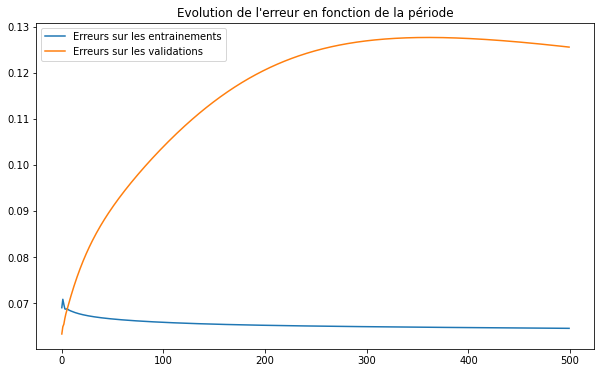

In [11]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

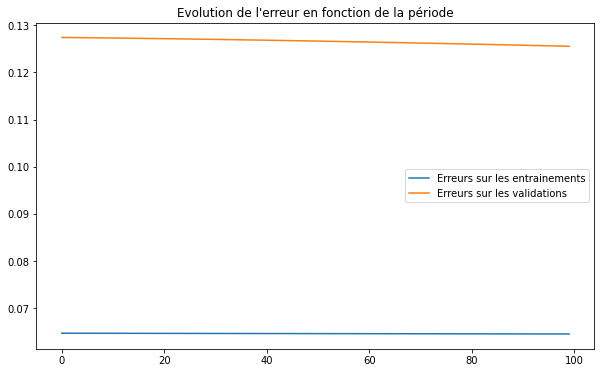

In [12]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [13]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

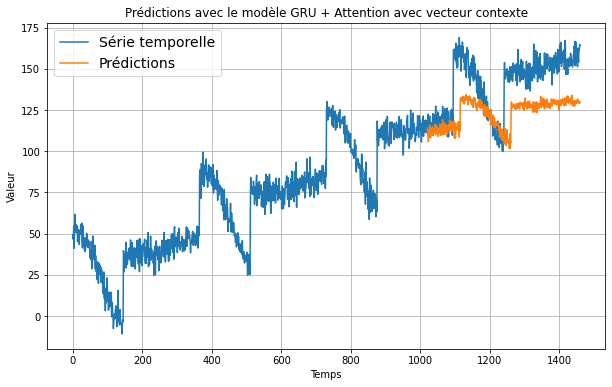

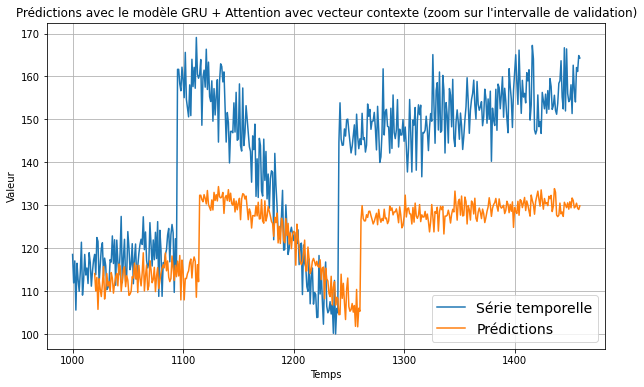

In [14]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle GRU + Attention avec vecteur contexte')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle GRU + Attention avec vecteur contexte (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

# Création du modèle LSTMN